In [41]:
pip install category-encoders

Note: you may need to restart the kernel to use updated packages.


In [42]:
import os
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, RobustScaler

from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, auc
from sklearn.utils.class_weight import compute_class_weight
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin
from sklearn.ensemble import IsolationForest

from category_encoders import TargetEncoder

from sklearn.utils.extmath import softmax


In [43]:

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
dfs = []
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(filename)
        dfs.append(pd.read_csv(os.path.join(dirname, filename)))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

sample_submission.csv
train.csv
test.csv


In [44]:
from sklearn.metrics import confusion_matrix, classification_report
from category_encoders import WOEEncoder
def generate_and_save_reports(models, x_val, y_val):
    reports = []
    n_rows = int(np.ceil(len(models) / 4))
    fig, axes = plt.subplots(nrows=n_rows, ncols=4, figsize=(20, n_rows * 5))
    axes = axes.flatten()

    for i, (model_name, model) in enumerate(models.items()):
        val_predictions = model.predict(x_val)
        
        conf_matrix = confusion_matrix(y_val, val_predictions)

        sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', ax=axes[i])
        axes[i].set_xlabel('Previsões')
        axes[i].set_ylabel('Verdadeiros')
        axes[i].set_title(f'Matriz de Confusão {model_name}')

        report = classification_report(y_val, val_predictions, output_dict=True, zero_division=0)
        for classe, metrics in report.items():
            if classe not in ["accuracy", "macro avg", "weighted avg"]:
                reports.append({
                    "Model": model_name,
                    "Class": classe,
                    "Precision": metrics["precision"],
                    "Recall": metrics["recall"],
                    "F1-Score": metrics["f1-score"],
                    "Support": metrics["support"]
                })

    plt.tight_layout()
    plt.show()
    plt.close(fig)
    reports_df = pd.DataFrame(reports)
    return reports_df

In [45]:
class RidgeClassifierWithProba(RidgeClassifier):
    def __init__(self, temperature=1.0, **kwargs):
        super().__init__(**kwargs)
        self.temperature = temperature

    def predict_proba(self, X):
        d = self.decision_function(X) / self.temperature
        if len(d.shape) == 1:
            d = np.c_[-d, d]
        return softmax(d)

In [46]:
class CustomCatBoostClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, cat_features=None, early_stopping_rounds=None, verbose=None, **kwargs):
        self.cat_features = cat_features
        self.early_stopping_rounds = early_stopping_rounds
        self.verbose = verbose
        self.model = CatBoostClassifier(**kwargs)
        
    def fit(self, X, y):
        self.model.fit(X, y, cat_features=self.cat_features,
                       early_stopping_rounds=self.early_stopping_rounds,
                       verbose=self.verbose)
        return self
    
    def predict(self, X):
        return self.model.predict(X)

    def predict_proba(self, X):
        return self.model.predict_proba(X)


In [47]:
class SoftVotingEnsemble:
    def __init__(self, models):
        self.models = models
    
    def predict_proba(self, X):
        sum_of_probs = None
        
        for model in self.models:
            probs = model.predict_proba(X)
            if sum_of_probs is None:
                sum_of_probs = probs
            else:
                sum_of_probs += probs
        
        avg_of_probs = sum_of_probs / len(self.models)
        
        return avg_of_probs
    
    def predict(self, X):
        avg_of_probs = self.predict_proba(X)
        predicted_classes = np.argmax(avg_of_probs, axis=1)
        return predicted_classes


In [48]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, numerical_features, categorical_features, encoding_features, model_type):
        self.model_type = model_type
        self.numerical_features = numerical_features
        self.categorical_features = categorical_features
        self.encoding_features = encoding_features

    def fit(self, X, y=None):
        match self.model_type:
            case 'CatBoost':
                self.selected_columns = self.numerical_features + self.categorical_features
                print(self.selected_columns)
            case _:
                self.selected_columns = self.numerical_features + self.encoding_features
        return self
    
    def transform(self, X):
        return X[self.selected_columns]

In [49]:
models_final_metrics = {
    "CatBoost": '',
    'Logistic Regression': '',
    'Random Forest': '',
    "Ridge": None,
    "LightGBM": None,
    "XGBoost": None
}


In [50]:
numerical_features = [ 'Age', 'Height', 'Weight', 'family_history_with_overweight',
       'FAVC', 'FCVC', 'NCP', 'CH2O', 'SCC', 'FAF', 'TUE', 'Gender'],

categorical_features = [ 'CAEC', 'CALC', 'MTRANS', 'FCVC_bins']

target_enc_features = [f"{i}_target_enc_feature" for i in categorical_features]
woe_enc_features = [f"{i}_woe" for i in categorical_features]

In [51]:
target = 'NObeyesdad'

In [52]:
target_enc_features

['CAEC_target_enc_feature',
 'CALC_target_enc_feature',
 'MTRANS_target_enc_feature',
 'FCVC_bins_target_enc_feature']

In [53]:
train_df = dfs[1]
test_df = dfs[2]

In [54]:
gender_mapping = {'Male':0, 'Female':1}
train_df['Gender'] = train_df['Gender'].map(gender_mapping)
family_mapping = {'yes':1, 'no':0}
train_df['family_history_with_overweight'] = train_df['family_history_with_overweight'].map(family_mapping)
FAVC_mapping = {'yes':1, 'no':0}
train_df['FAVC'] = train_df['FAVC'].map(FAVC_mapping)
SCC_mapping = {'yes':1, 'no':0}
train_df['SCC'] = train_df['SCC'].map(SCC_mapping)
train_df.drop(columns = 'SMOKE', inplace = True)

In [55]:
numerical_columns = train_df.select_dtypes(include=[float, int]).columns

In [56]:
train_df["FCVC_bins"] = pd.cut(train_df["FCVC"], bins=[0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5])

In [57]:
train_df['FCVC_bins'] = train_df['FCVC_bins'].apply(lambda x: str(x))

In [58]:
train_df.drop(columns="FCVC", inplace=True)

In [59]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [60]:
label_encoder = LabelEncoder()

In [61]:
train_df[target] = label_encoder.fit_transform(train_df[target])

In [62]:
for i in categorical_features:
    train_df[i] = train_df[i].astype("category")

In [63]:
def preprocess_dataset(df, categorical_features, label_encoder):
    gender_mapping = {'Male':0, 'Female':1}
    df['Gender'] = df['Gender'].map(gender_mapping)
    family_mapping = {'yes':1, 'no':0}
    df['family_history_with_overweight'] = df['family_history_with_overweight'].map(family_mapping)
    FAVC_mapping = {'yes':1, 'no':0}
    df['FAVC'] = df['FAVC'].map(FAVC_mapping)
    SCC_mapping = {'yes':1, 'no':0}
    df['SCC'] = df['SCC'].map(SCC_mapping)
    df.drop(columns = 'SMOKE', inplace = True)    
    df["Weight"] = np.log1p(df["Weight"])
    df["Height"] = np.log1p(df["Height"])
    
    df["FCVC_bins"] = pd.cut(df["FCVC"], bins=[0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5])
    df['FCVC_bins'] = df['FCVC_bins'].apply(lambda x: str(x))
    df.drop(columns = "FCVC")
    for i in categorical_features:
        df[i] = df[i].astype("category")
    
    return df, label_encoder

In [64]:
df_transformed, label_encoder = preprocess_dataset(test_df, categorical_features,
                                                  label_encoder)

In [65]:
woe_encoder = WOEEncoder(cols=categorical_features)


In [66]:
numerical_features = ['Age',
 'Height',
 'Weight',
 'family_history_with_overweight',
 'FAVC',
 'NCP',
 'CH2O',
 'SCC',
 'FAF',
 'TUE',
 'Gender']

In [67]:
x_train, x_test, y_train, y_test = train_test_split(train_df[numerical_features + categorical_features], train_df[target], test_size=0.20, random_state=42)

In [68]:
enc = TargetEncoder(cols=categorical_features)
woe_encoder = WOEEncoder(cols=categorical_features)


In [69]:
training_numeric_dataset = enc.fit_transform(x_train[categorical_features], y_train).add_suffix("_target_enc_feature")
testing_numeric_dataset = enc.transform(x_test[categorical_features]).add_suffix("_target_enc_feature")


In [70]:
val_test_df = enc.transform(df_transformed[categorical_features]).add_suffix("_target_enc_feature")

In [71]:
df_transformed = pd.concat([df_transformed, val_test_df], axis=1)

In [72]:
x_train = pd.concat([x_train, training_numeric_dataset], axis=1)

In [73]:
x_test = pd.concat([x_test, testing_numeric_dataset], axis=1)

In [74]:
sklearn_models = {
    'Ridge': RidgeClassifierWithProba,
    'Logistic Regression': LogisticRegression,
    "CatBoost": CustomCatBoostClassifier,
    "LightGBM": LGBMClassifier,
    "XGBoost": XGBClassifier,
    'Random Forest': RandomForestClassifier,
    'Gradient Boosting': GradientBoostingClassifier,
    "ExtraTree": ExtraTreesClassifier,
    "BaggingModel": BaggingClassifier,


}

models_final_params = {
    'CatBoost': {'depth': 10, 'n_estimators': 1000,
                "cat_features": categorical_features,
              "early_stopping_rounds": 222, "verbose": False},
    'XGBoost': {
                'n_estimators': 500,},
    'LightGBM': {'colsample_bytree': 0.33334105953783183, 'n_estimators': 500},
    'Random Forest': {'n_estimators': 500},
    'Ridge': {},
    'Logistic Regression': {},
    'Gradient Boosting': {},
    "ExtraTree": {},
    "Knn":  {},
    "BaggingModel":  {},

}

model_auc = {
    "CatBoost": '',
    'Logistic Regression': '',
    'Random Forest': '',
    "Ridge": None,
    "LightGBM": None,
    "XGBoost": None,
    'Gradient Boosting': {},
    "ExtraTree": {},
    "BaggingModel":  {},

}

pipelines = {}
for model_name, params in models_final_params.items():
    if model_name in sklearn_models:
        if model_name in ('Logistic Regression', 'Ridge'):
            pipeline = make_pipeline(
            FeatureSelector(numerical_features, categorical_features, target_enc_features,
                   model_type=model_name),
            RobustScaler(),
            sklearn_models[model_name](**params)
        )
            
        else:
            pipeline = make_pipeline(
            FeatureSelector(numerical_features, categorical_features, target_enc_features,
                   model_type=model_name),
            sklearn_models[model_name](**params))

        
        pipelines[model_name] = pipeline

In [75]:
from sklearn.metrics import roc_auc_score

for model_name, pipeline in pipelines.items():
    print(model_name)
    pipeline.fit(x_train, y_train)
    y_pred = pipeline.predict_proba(x_test)
    roc_auc = roc_auc_score(y_test, y_pred, multi_class='ovr')
    model_auc[model_name] = roc_auc

CatBoost
['Age', 'Height', 'Weight', 'family_history_with_overweight', 'FAVC', 'NCP', 'CH2O', 'SCC', 'FAF', 'TUE', 'Gender', 'CAEC', 'CALC', 'MTRANS', 'FCVC_bins']
XGBoost
LightGBM
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005533 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1804
[LightGBM] [Info] Number of data points in the train set: 16606, number of used features: 15
[LightGBM] [Info] Start training from score -2.117117
[LightGBM] [Info] Start training from score -1.911230
[LightGBM] [Info] Start training from score -1.948141
[LightGBM] [Info] Start training from score -1.857720
[LightGBM] [Info] Start training from score -1.633574
[LightGBM] [Info] Start training from score -2.145531
[LightGBM] [Info] Start training from score -2.112625
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [W

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Gradient Boosting
ExtraTree
BaggingModel


In [76]:
metrics = pd.DataFrame.from_dict(model_auc, orient='index', columns=["AUC"]).sort_values("AUC", ascending=False)

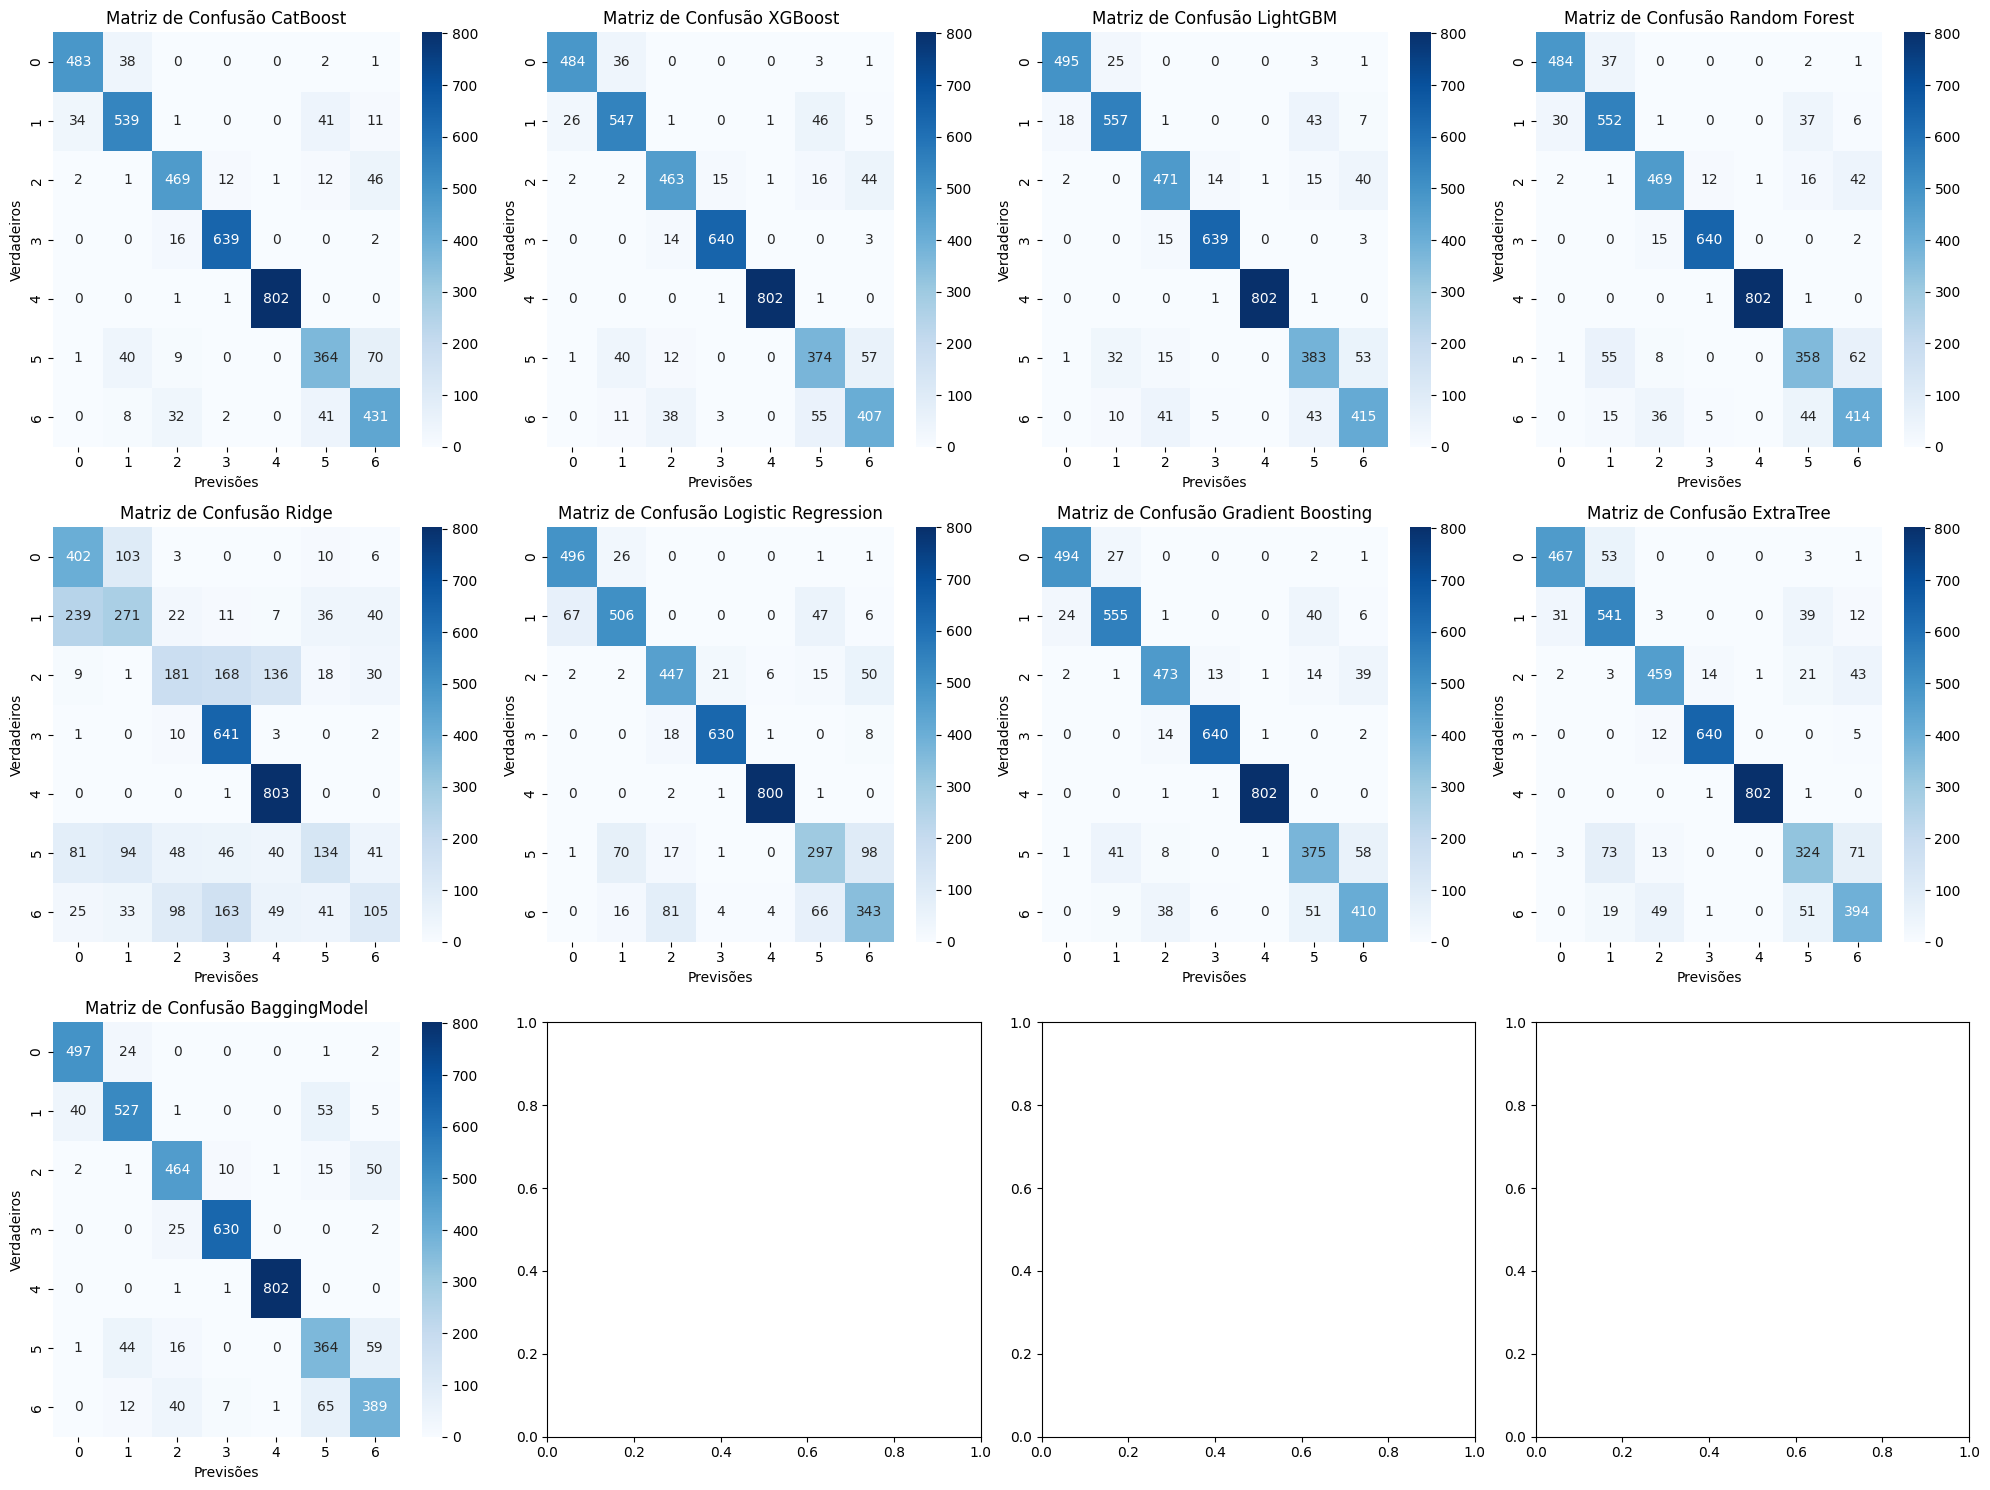

,Model,Class,Precision,Recall,F1-Score,Support
0,CatBoost,0,0.928846,0.921756,0.925287,524
1,CatBoost,1,0.861022,0.861022,0.861022,626
2,CatBoost,2,0.888258,0.863720,0.875817,543
3,CatBoost,3,0.977064,0.972603,0.974828,657
4,CatBoost,4,0.998755,0.997512,0.998133,804
...,...,...,...,...,...,...
58,BaggingModel,2,0.848263,0.854512,0.851376,543
59,BaggingModel,3,0.972222,0.958904,0.965517,657
60,BaggingModel,4,0.997512,0.997512,0.997512,804
61,BaggingModel,5,0.730924,0.752066,0.741344,484


In [77]:
import matplotlib.pyplot as plt
generate_and_save_reports(pipelines, x_test, y_test)

In [78]:
metrics[metrics.AUC >= 0.97].index

Index(['Gradient Boosting', 'LightGBM', 'CatBoost', 'XGBoost', 'Random Forest',
       'ExtraTree', 'Logistic Regression', 'BaggingModel'],
      dtype='object')

In [79]:
estimators = [pipelines[model] for model in metrics[metrics.AUC >= 0.97].index]

In [80]:
ensemble = SoftVotingEnsemble(estimators)

In [81]:
y_pred = ensemble.predict_proba(x_test)
roc_auc = roc_auc_score(y_test, y_pred, multi_class='ovr')


In [82]:
model_auc["Ensemble"] = roc_auc

In [83]:
metrics = pd.DataFrame.from_dict(model_auc, orient='index', columns=["AUC"]).sort_values("AUC", ascending=False)

In [84]:
pipelines['ensemble'] = ensemble

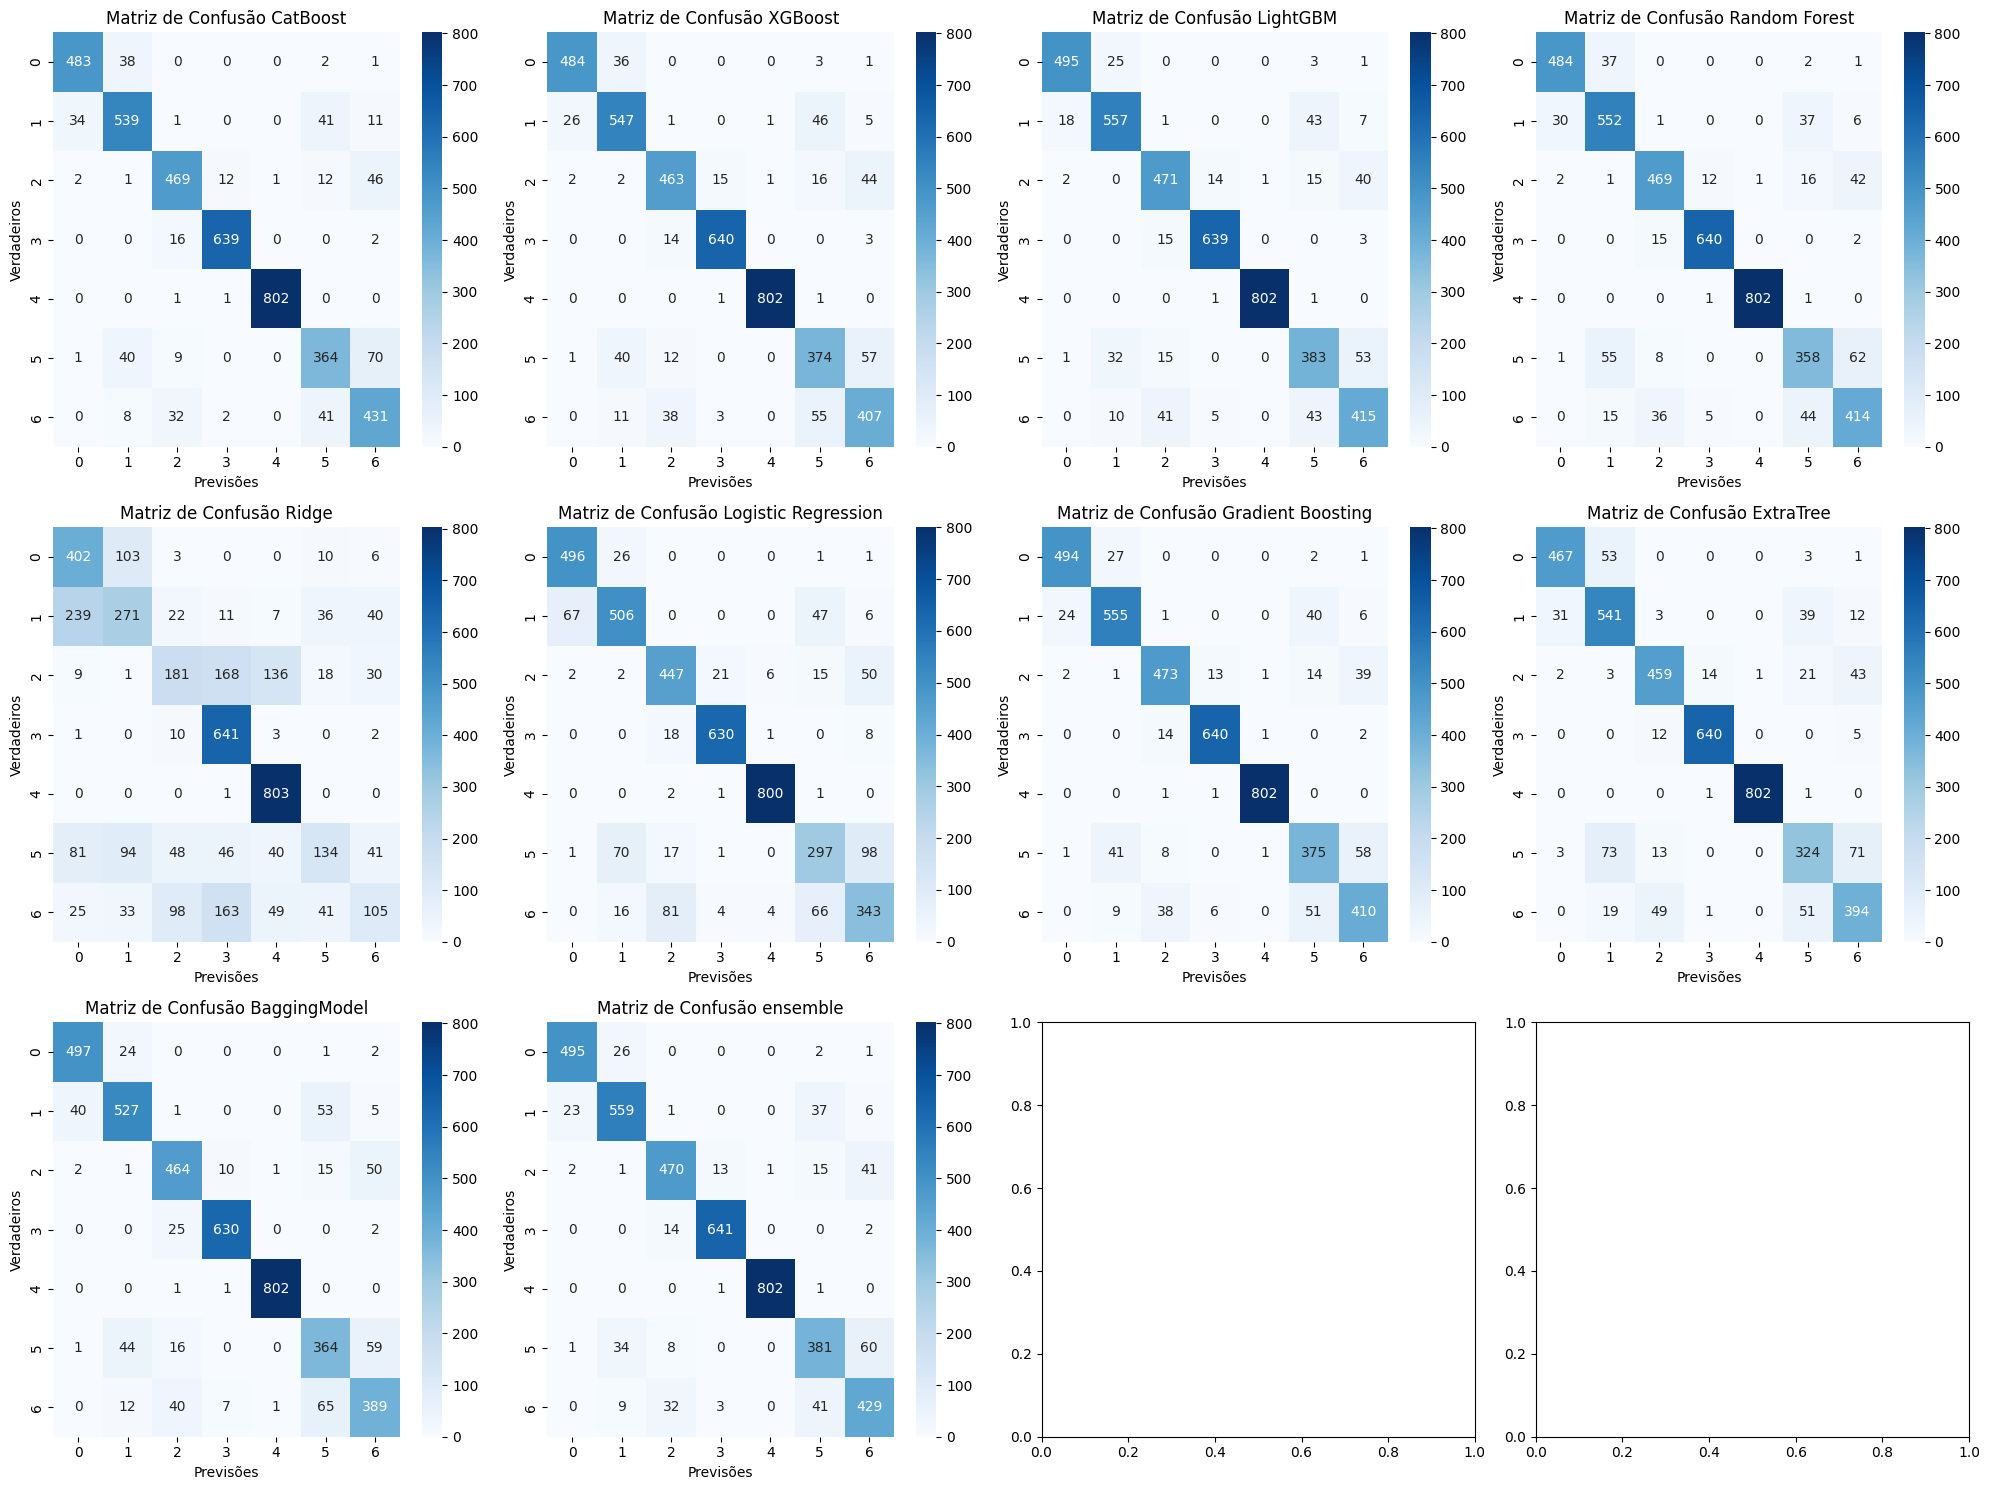

,Model,Class,Precision,Recall,F1-Score,Support
0,CatBoost,0,0.928846,0.921756,0.925287,524
1,CatBoost,1,0.861022,0.861022,0.861022,626
2,CatBoost,2,0.888258,0.863720,0.875817,543
3,CatBoost,3,0.977064,0.972603,0.974828,657
4,CatBoost,4,0.998755,0.997512,0.998133,804
...,...,...,...,...,...,...
65,ensemble,2,0.895238,0.865562,0.880150,543
66,ensemble,3,0.974164,0.975647,0.974905,657
67,ensemble,4,0.998755,0.997512,0.998133,804
68,ensemble,5,0.798742,0.787190,0.792924,484


In [85]:
generate_and_save_reports(pipelines, x_test, y_test)

In [86]:
def highlight_max_auc(s):
    is_max = s == s.max()
    return ['background-color: green' if v else '' for v in is_max]

metrics.style.apply(highlight_max_auc, subset=['AUC'])

,AUC
Ensemble,0.989109
Gradient Boosting,0.988662
LightGBM,0.988296
CatBoost,0.987953
XGBoost,0.987430
Random Forest,0.986459
ExtraTree,0.980610
Logistic Regression,0.975143
BaggingModel,0.973461
Ridge,0.894092


# Best Model was Ensemble (Combining best models with AUC >= 0.97)

# Predicting Val dataset

In [87]:
submitted_df = pd.DataFrame()

In [88]:
y_val = pipelines["ensemble"].predict(df_transformed)

In [89]:
y_val

array([0, 0, 0, ..., 0, 0, 0])

In [90]:
label_encoder.inverse_transform(y_val)

array(['Insufficient_Weight', 'Insufficient_Weight',
       'Insufficient_Weight', ..., 'Insufficient_Weight',
       'Insufficient_Weight', 'Insufficient_Weight'], dtype=object)

In [91]:
submitted_df["id"] = df_transformed["id"]
submitted_df["NObeyesdad"] = label_encoder.inverse_transform(y_val)

In [92]:
submitted_df.to_csv("submission.csv", index=False)